<a href="https://colab.research.google.com/github/jihor/colab/blob/main/rshb_orgstruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt install libgraphviz-dev
!pip install pygraphviz #ебаный pygraphviz, как можно так хуёво вставать! Пиздец!
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64

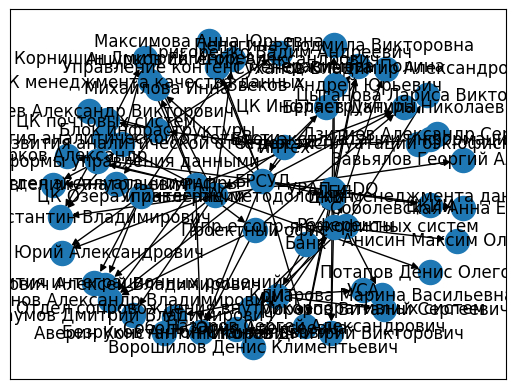

In [ ]:
import networkx as nx
#g = nx.from_pandas_edgelist(df)
#G = nx.complete_graph(5)

import pandas as pd
pd.options.display.max_columns = 20

#vals = [["a","Head :: Dpt1"],["b","Head :: Dpt2"],["c","Head :: Dpt1 :: Team1"]]
#df = pd.DataFrame(vals, columns=["name", "dpt"])
df = pd.read_excel("Контакты.xlsx")
G = nx.DiGraph()

def populate(row):
  a = None
  for j in (row.dpt.split(" :: ")):
    if a is None:
      a = j
      continue
       #print(a + "->" + j)
    G.add_edge(a, j)
    a = j
    G.add_edge(j, row.fio)

df.apply(populate, axis=1)

pos = nx.spring_layout(G)
nx.draw_networkx(G,pos)

#nx.draw(G, with_labels=True)

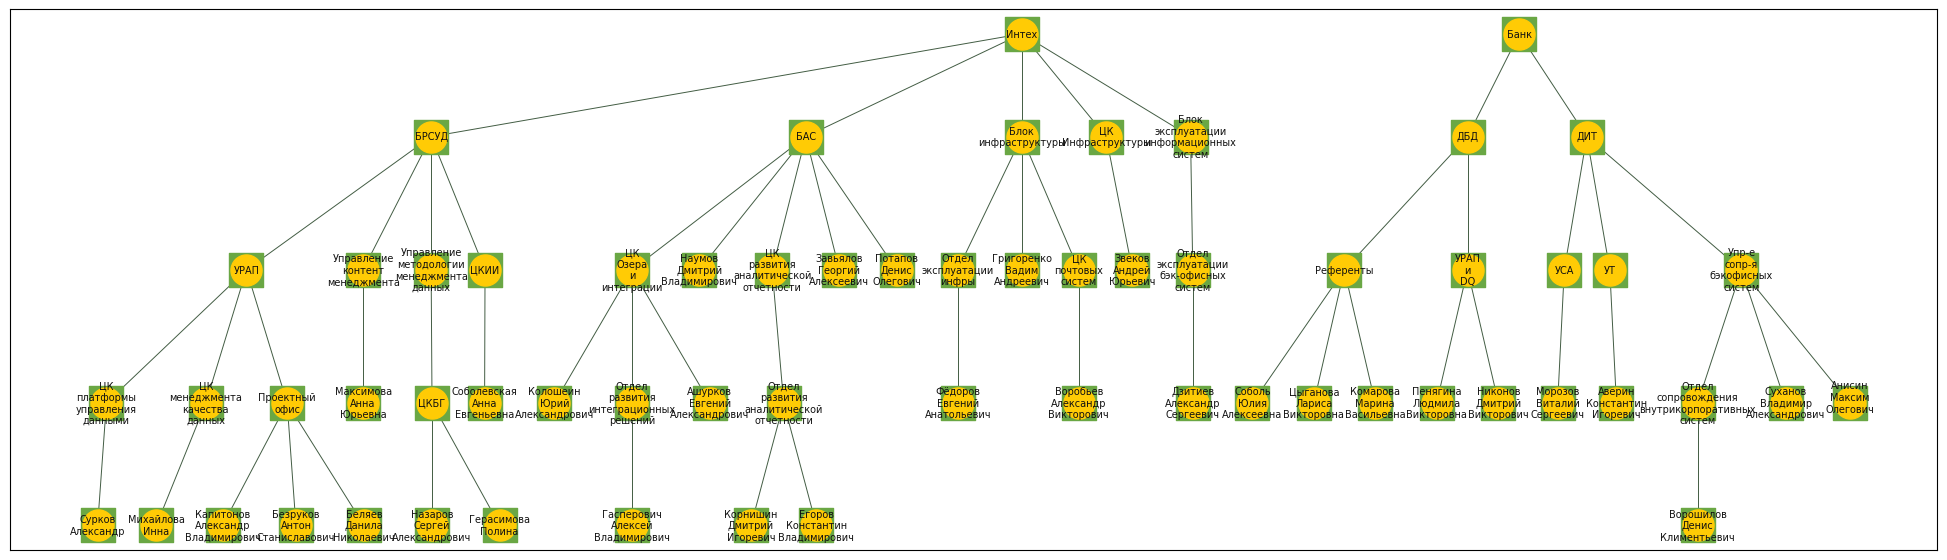

In [ ]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_columns = 20

df = pd.read_excel("Контакты.xlsx")
G = nx.DiGraph()

def populate(row):
  a = None
  for j in (row.dpt.split(" :: ")):
    j = j.replace(" ","\n")
    if a is None:
      a = j
      continue
      #print(a + "->" + j)
    G.add_edge(a, j)
    a = j
  fio = row.fio.replace(" ","\n")
  G.add_edge(j, fio)

df = df[df.dpt.str.contains(" :: ")]
df.apply(populate, axis=1)

fig, ax = plt.subplots(figsize=(20, 6))
fig.tight_layout()
ax.margins(x=0, y=0)
#ax.set_axis_off()


pos = graphviz_layout(G, prog="dot", args='-Grankdir="UD"')
nx.draw_networkx_nodes(G, pos, node_color="#6AA744", node_shape='s', node_size=600)
nx.draw_networkx_nodes(G, pos, node_color="#FFCB05", node_shape='o', node_size=500)
nx.draw_networkx_labels(G, pos, font_size=7, font_color="#111111")
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="#425C43", width=0.7, arrows=False)

plt.show()

In [5]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from dash import Dash, html, dcc
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
from dash.dependencies import Input, Output

G = nx.DiGraph()
DF = pd.read_excel("contacts.xlsx")
DF = DF[DF.dpt.str.contains(" :: ")]

def populate(row):
  a = None
  for j in (row.dpt.split(" :: ")):
    j = j.replace(" ","<br>")
    if a is None:
      a = j
      continue
      #print(a + "->" + j)
    G.add_edge(a, j)
    a = j
  fio = row.fio.replace(" ","<br>")
  fio = fio + "<br><b>" + row.cmnt + "</b>"
  G.add_edge(j, fio)

def networkGraph(filter):
    df = DF
    G.clear()
    if filter:
        df = df.dropna(axis=0, subset=['cmnt'])
        df = df[(df.cmnt.str.contains(filter, case=False)) | (df.dpt.str.contains(filter, case=False))]
    df.apply(populate, axis=1)

    pos = graphviz_layout(G, prog="dot", args='-Grankdir="UD"')

    # edges trace
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(color='#425C43', width=0.7),
        hoverinfo='none',
        showlegend=False,
        mode='lines')

    # nodes trace
    node_x = []
    node_y = []
    text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        text.append(node)

    node_trace1 = go.Scatter(
        x=node_x, y=node_y, text=text,
        mode='markers',
        showlegend=False,
        hoverinfo='none',
        marker=dict(
            color='#6AA744',
            symbol="square",
            size=60))

    node_trace2 = go.Scatter(
        x=node_x, y=node_y, text=text,
        mode='markers+text',
        showlegend=False,
        hoverinfo='none',
        textfont=dict(
            color="#111111",
            size=11),
        marker=dict(
            color='#FFCB05',
            size=50))

    # layout
    layout = dict(plot_bgcolor='white',
                  paper_bgcolor='white',
                  margin=dict(t=10, b=10, l=10, r=10, pad=0),
                  xaxis=dict(linecolor='black',
                             showgrid=False,
                             showticklabels=False,
                             mirror=True),
                  yaxis=dict(linecolor='black',
                             showgrid=False,
                             showticklabels=False,
                             mirror=True))

    # figure

    fig = go.Figure(data=[edge_trace, node_trace1, node_trace2], layout=layout)

    return fig

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash(__name__, external_stylesheets=external_stylesheets)


app.layout = html.Div([
        html.I("Filter by:"),
        html.Br(),
        dcc.Input(id="filter", type="text", placeholder="Озеро"),
        dcc.Graph(id='my-graph', config = {'scrollZoom': True})
    ]
)

@app.callback(
    Output("my-graph", "figure"),
    [Input("filter", "value")],
)
def update_output(filter):
    return networkGraph(filter)

app.run_server(mode='inline',host="0.0.0.0",port=1005)

<IPython.core.display.Javascript object>